In [38]:
import os
import time
import uuid
import cv2

In [51]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 30

In [40]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:786: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


In [41]:
!labelme

C:\Users\tehze\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
2024-04-17 13:07:49,499 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\tehze\.labelmerc


In [42]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [43]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [44]:
tf.config.list_physical_devices('GPU')

[]

In [45]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [52]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [53]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [48]:
images = images.map(load_image)

NameError: name 'images' is not defined

In [49]:
images.as_numpy_iterator().next()

NameError: name 'images' is not defined

In [50]:
type(images)

NameError: name 'images' is not defined

In [10]:
image_generator = images.batch(4).as_numpy_iterator()

In [11]:
plot_images = image_generator.next()

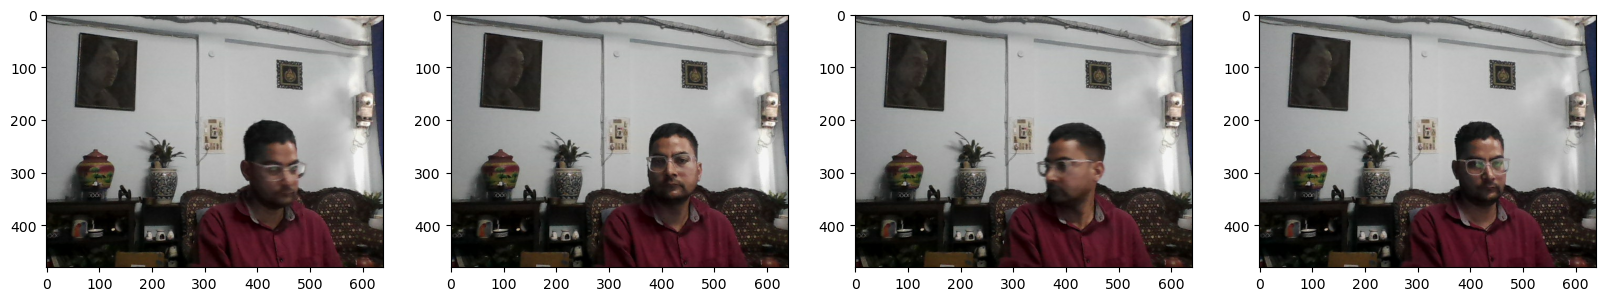

In [12]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

In [25]:
30*.7

21.0

In [26]:
30*.15

4.5

In [27]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath) 

In [9]:
import albumentations as alb

In [10]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

In [11]:
img = cv2.imread(os.path.join('data','train', 'images','33404a5c-fbd1-11ee-a8ed-e00fc6f40cb4.jpg'))

In [12]:
with open(os.path.join('data', 'train', 'labels', '33404a5c-fbd1-11ee-a8ed-e00fc6f40cb4.json'), 'r') as f:
    label = json.load(f)

In [13]:
label['shapes'][0]['points']

[[356.88524590163934, 200.65573770491804],
 [488.8524590163935, 366.2295081967213]]

In [14]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [15]:
coords

[356.88524590163934, 200.65573770491804, 488.8524590163935, 366.2295081967213]

In [16]:
coords = list(np.divide(coords, [640,480,640,480]))

In [17]:
coords

[0.5576331967213115,
 0.4180327868852459,
 0.7638319672131149,
 0.7629781420765027]

In [18]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [19]:
augmented['bboxes'][0][2:]

(0.2602550091074681, 0.6029872495446266)

In [20]:
augmented['bboxes']

[(0.0, 0.23504553734061928, 0.2602550091074681, 0.6029872495446266)]

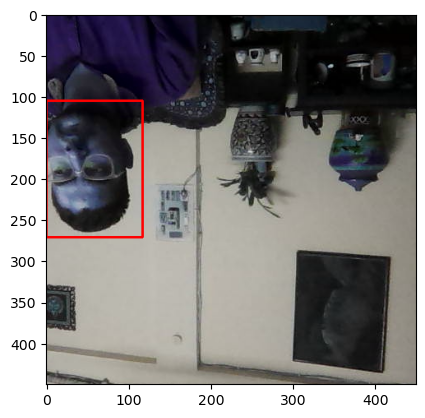

In [21]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

In [22]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(30):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

In [32]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

NameError: name 'load_image' is not defined

In [ ]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [ ]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

In [24]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

In [25]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [26]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [27]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.604 , 0.4082, 0.8975, 0.776 ], dtype=float16))

In [31]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

NameError: name 'test_images' is not defined

In [55]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [56]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [57]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [58]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.     , 0.2391 , 0.2134 , 0.5796 ],
        [0.10724, 0.3625 , 0.4077 , 0.776  ],
        [0.7627 , 0.4175 , 1.     , 0.8237 ],
        [0.3584 , 0.253  , 0.6665 , 0.6265 ],
        [0.7783 , 0.1752 , 1.     , 0.554  ],
        [0.4336 , 0.4197 , 0.7144 , 0.8257 ],
        [0.7153 , 0.268  , 0.9814 , 0.6084 ],
        [0.2637 , 0.3596 , 0.544  , 0.7656 ]], dtype=float16))

In [62]:
data_samples = train.as_numpy_iterator()

In [63]:
res = data_samples.next()

In [4]:
fig, ax = plt.subplots(ncols=2, figsize=(20,20))
for idx in range(2): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [30,30]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [30,30]).astype(int)), 
                        (120,0,0), 2)

    ax[idx].imshow(sample_image)

NameError: name 'plt' is not defined

In [66]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

In [67]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 18s 0us/step


In [68]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [69]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [70]:
facetracker = build_model()

In [71]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 vgg16 (Functional)          (None, None, None, 512)      1471468   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 global_max_pooling2d (Glob  (None, 512)                  0         ['vgg16[0][0]']               
 alMaxPooling2D)                                                                                  
                                                                                              

In [72]:
X, y = train.as_numpy_iterator().next()

In [73]:
X.shape

(8, 120, 120, 3)

In [74]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 3s 3s/step


In [75]:
classes, coords

(array([[0.6799341 ],
        [0.6963256 ],
        [0.7043043 ],
        [0.6659016 ],
        [0.67626643],
        [0.70718104],
        [0.66642094],
        [0.6421272 ]], dtype=float32),
 array([[0.3745858 , 0.55467266, 0.24968679, 0.7102987 ],
        [0.39533123, 0.54519343, 0.26630768, 0.7120738 ],
        [0.40012947, 0.52430904, 0.25918356, 0.7192811 ],
        [0.31799975, 0.6296453 , 0.24040146, 0.67795163],
        [0.35571688, 0.6291749 , 0.24770577, 0.6548974 ],
        [0.46386054, 0.5489268 , 0.26870608, 0.658482  ],
        [0.44966215, 0.52745056, 0.23080818, 0.70012414],
        [0.3815289 , 0.5568559 , 0.21510561, 0.67494357]], dtype=float32))

In [78]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [93]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=lr_decay)

In [81]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [82]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [83]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.339038>

In [84]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.38641167>

In [85]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.339038>

In [3]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

NameError: name 'Model' is not defined

In [90]:
model = FaceTracker(facetracker)

In [94]:
model.compile(opt, classloss, regressloss)

In [95]:
logdir='logs'

In [96]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [97]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
79/79 [==============================] - 337s 4s/step - total_loss: 9.4106 - class_loss: 0.0047 - regress_loss: 9.4083 - val_total_loss: 7.6266 - val_class_loss: 0.0000e+00 - val_regress_loss: 7.6266
Epoch 2/10
79/79 [==============================] - 344s 4s/step - total_loss: 9.4922 - class_loss: 0.0000e+00 - regress_loss: 9.4922 - val_total_loss: 7.9222 - val_class_loss: 0.0000e+00 - val_regress_loss: 7.9222
Epoch 3/10
79/79 [==============================] - 348s 4s/step - total_loss: 9.4901 - class_loss: 0.0000e+00 - regress_loss: 9.4901 - val_total_loss: 7.4098 - val_class_loss: 0.0000e+00 - val_regress_loss: 7.4098
Epoch 4/10
79/79 [==============================] - 333s 4s/step - total_loss: 9.4922 - class_loss: 0.0000e+00 - regress_loss: 9.4922 - val_total_loss: 8.2873 - val_class_loss: 0.0000e+00 - val_regress_loss: 8.2873
Epoch 5/10
79/79 [==============================] - 332s 4s/step - total_loss: 9.4936 - class_loss: 0.0000e+00 - regress_loss: 9.4936 - val_tota

In [98]:
hist.history

{'total_loss': [7.0275163650512695,
  7.153955459594727,
  6.986225128173828,
  7.150449275970459,
  7.265268325805664,
  6.904324531555176,
  6.798608779907227,
  7.660993576049805,
  7.654294013977051,
  6.697073459625244],
 'class_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'regress_loss': [7.0275163650512695,
  7.153955459594727,
  6.986225128173828,
  7.150449275970459,
  7.265268325805664,
  6.904324531555176,
  6.798608779907227,
  7.660993576049805,
  7.654294013977051,
  6.697073459625244],
 'val_total_loss': [7.626631736755371,
  7.922192573547363,
  7.409811496734619,
  8.28729248046875,
  7.263343811035156,
  7.843271255493164,
  7.365577220916748,
  8.006388664245605,
  7.433368682861328,
  7.28409481048584],
 'val_class_loss': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 'val_regress_loss': [7.626631736755371,
  7.922192573547363,
  7.409811496734619,
  8.28729248046875,
  7.263343811035156,
  7.843271255493164,
  7.365577220916748,
  8.00638866424

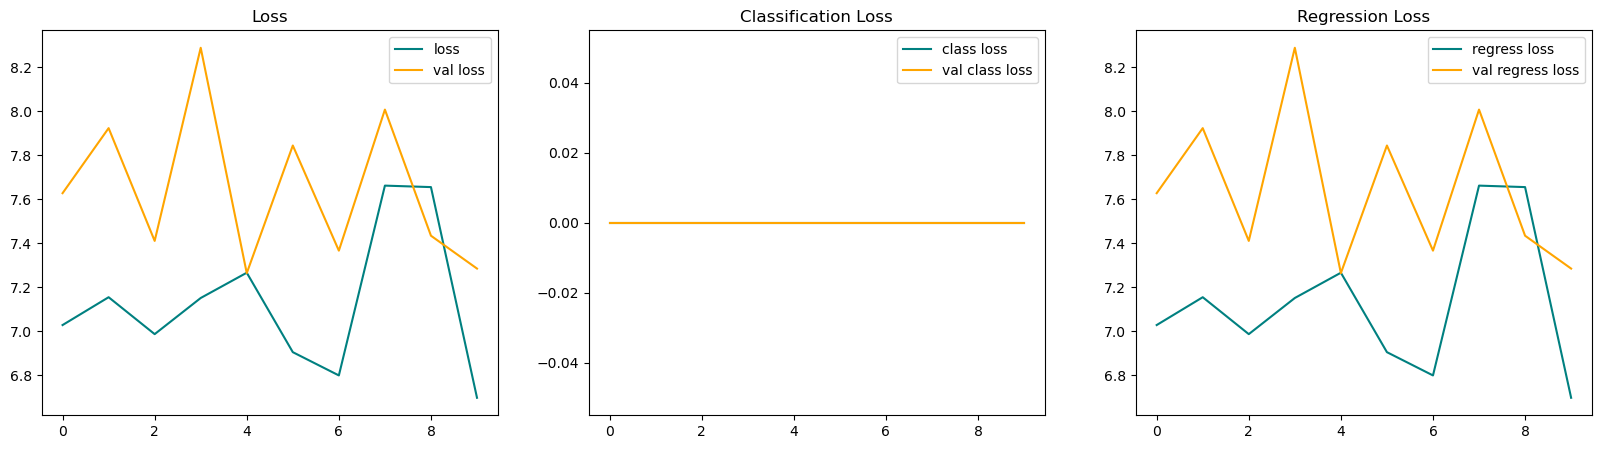

In [99]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [100]:
test_data = test.as_numpy_iterator()

In [101]:
test_sample = test_data.next()

In [102]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 482ms/step


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'
>  - img marked as output argument, but provided NumPy array marked as readonly
>  - Expected Ptr<cv::UMat> for argument 'img'


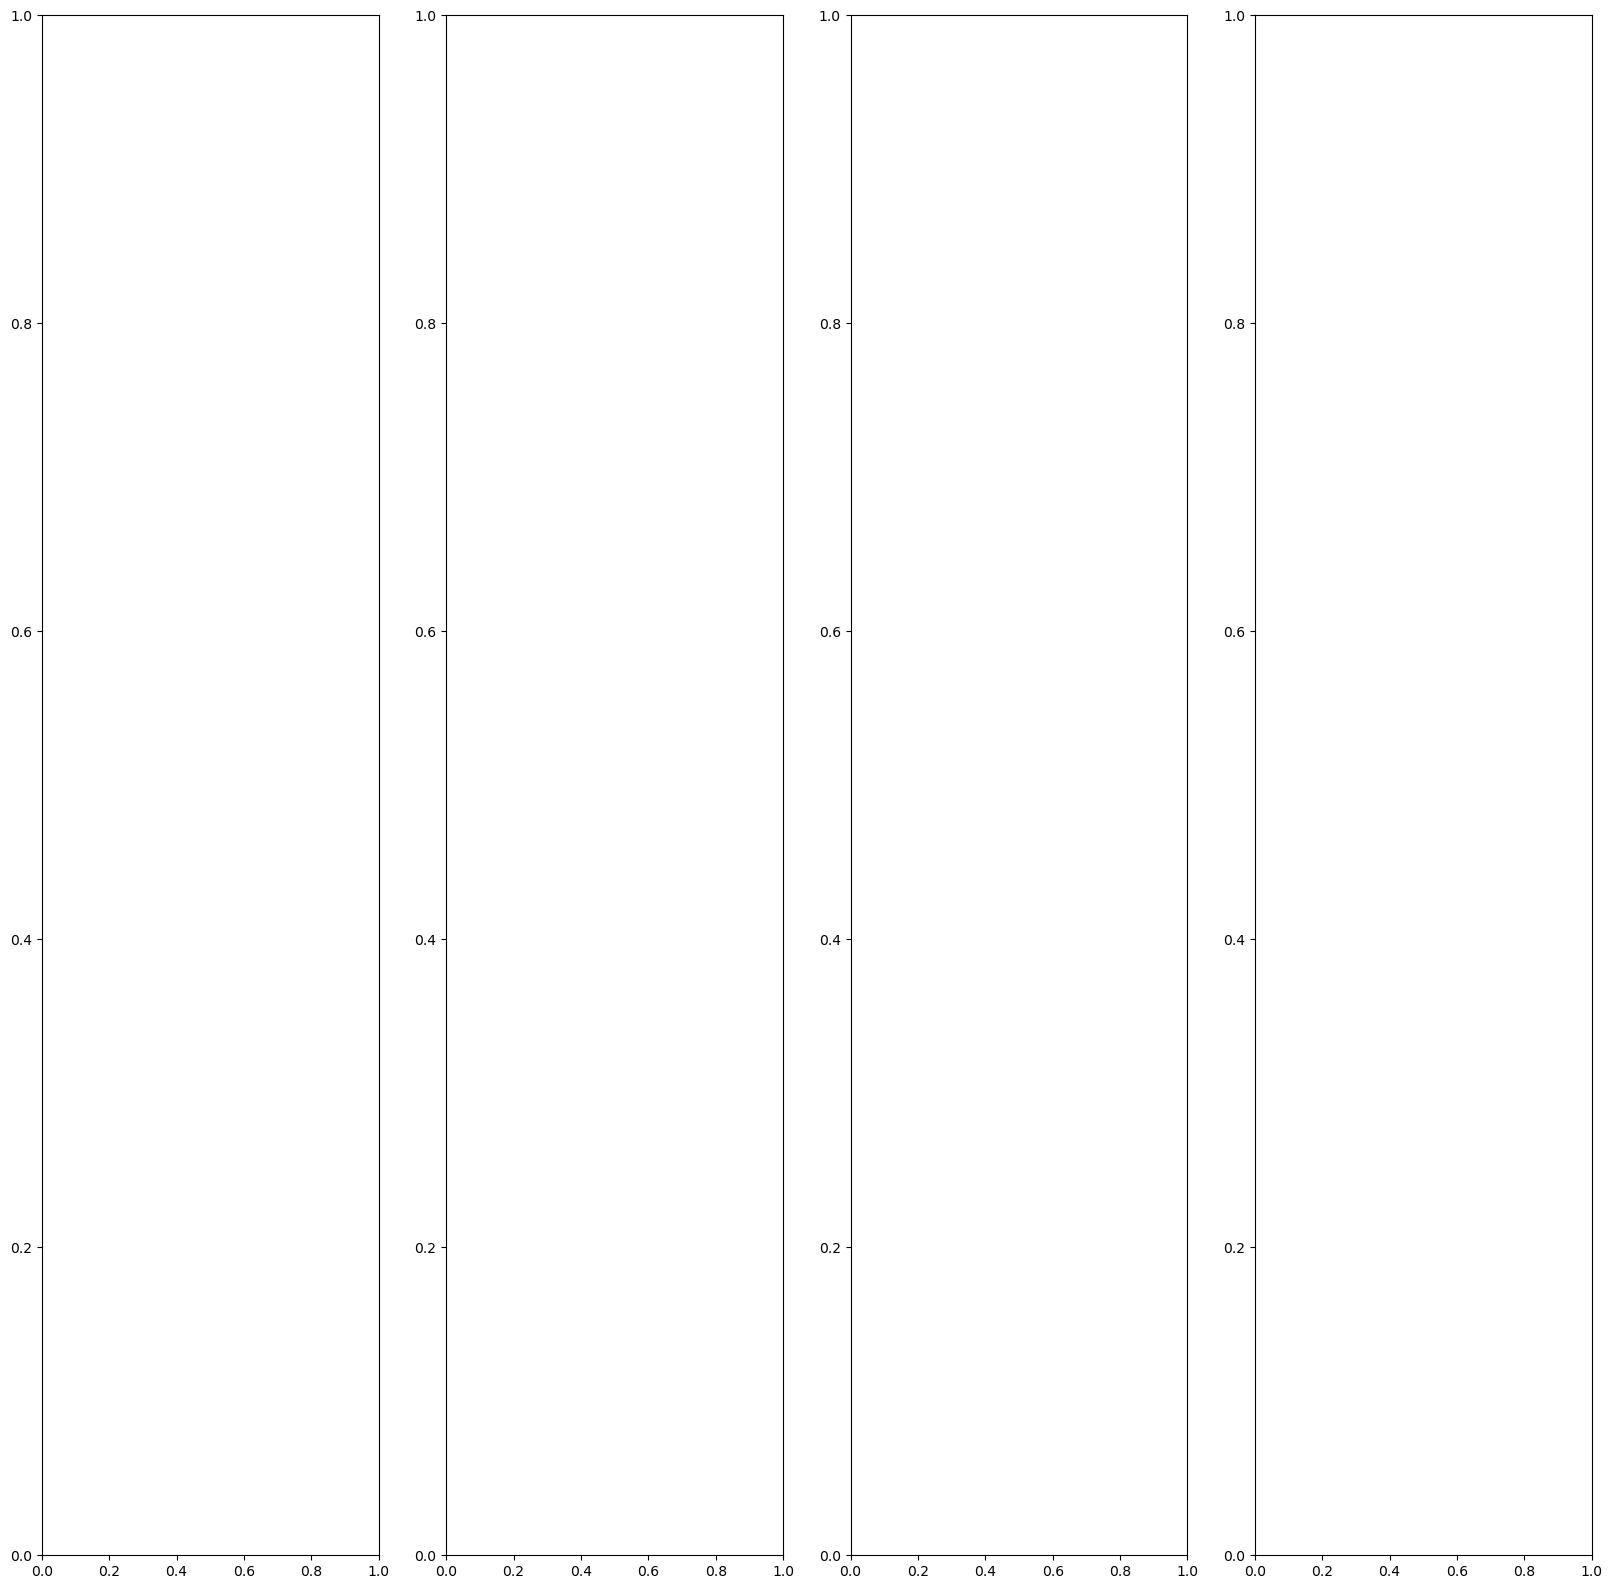

In [103]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

In [1]:
from tensorflow.keras.models import load_model

In [2]:
facetracker.save('facetracker.h5')

NameError: name 'facetracker' is not defined

In [106]:
facetracker = load_model('facetracker.h5')

In [54]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

TypeError: 'NoneType' object is not subscriptable